# Analysis of Autonomous Systems

We will discuss a variety of methods for analyzing the behavior of autonomous systems.

Reading: none

Assignment: Runs simulations to characterize collision avoidance performance against a variety of metrics; develop methods for visualizing the decision making behavior of your system.

## Measuring System Effectiveness

It is the designer's responsibility to go back to the field and assess the impact that the autonomous system is having. This measurement process must be both qualitative and quantitative.

__qualitative__: Deals with the _quality_ of a result. Does the policy followed by the agent look good? Is it behaving reasonably?

__quantitative__: Objective values that can be quantified. For example, with ACAS X, one should look at operational data on airborne collisions, near-misses, and separation after ACAS X has been put into place.

## Reward

Autonomous agents are often trained to maximize their reward. Does your agent receive high reward? That's all you care about, right?

Wrong.



< GIF from Max of agents optimizing rewards but doing weird stuff>

We care about the performance of the system in the real world, and the real world is never perfectly modeled.

## The Pareto Frontier

When optimizing a real-world system one often must balance a large number of trade-offs.

Which of the following is better?

- an airborne collision avoidance system that has 1 collision and 1000 alerts per million flight hours
- an airborne collision avoidance system that has 2 collisions and 10 alerts per million flight hours

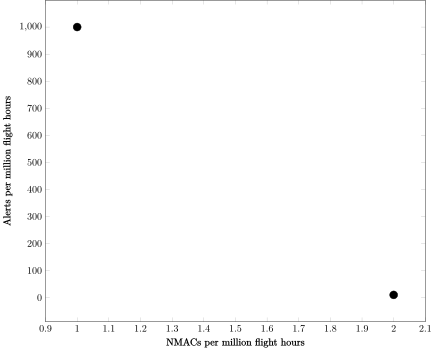

In [1]:
using PGFPlots

Axis(PGFPlots.Plots.Linear([1,2],[1000,10],style="color=black, mark=*, draw=none, mark options={scale=2, fill=black}"), 
     xlabel="NMACs per million flight hours", ylabel="Alerts per million flight hours", width="15cm")

Fewer collisions are good, and fewer alerts are good, but we cannot say which collision system is better without making a judgement on their relative value.

We know, therefore, that if we have a set of policies:

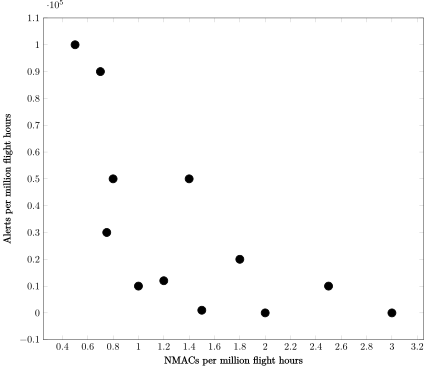

In [2]:
Axis(PGFPlots.Plots.Linear([0.5,0.75,1,1.5,2,3,1.8,0.8,2.5,1.2,0.7,1.4],[1e5,3e4,1e4,1e3,10,2,2e4,5e4,1e4,1.2e4,9e4,5e4],style="thick, black, mark=*, draw=none, mark options={scale=2, fill=black}"),
     xlabel="NMACs per million flight hours", ylabel="Alerts per million flight hours", width="15cm")

The policies that are potentially the best are those which cannot be shifted to be made better in both respects:

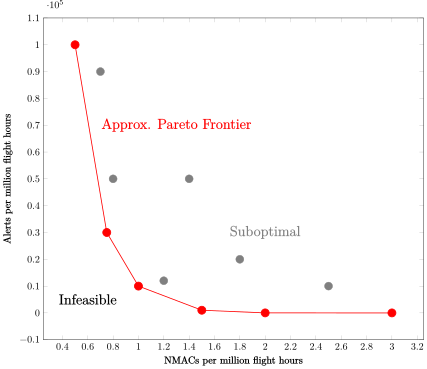

In [3]:
Axis([Plots.Linear([0.5,0.75,1,1.5,2,3],[1e5,3e4,1e4,1e3,10,2],style="thick, red, mark=*, mark options={scale=2, fill=red}"),
    Plots.Linear([1.8,0.8,2.5,1.2,0.7,1.4],[2e4,5e4,1e4,1.2e4,9e4,5e4],style="color=gray, mark=*, draw=none, mark options={scale=2, fill=gray}"),
    Plots.Node("\\Large Approx. Pareto Frontier",1.3,7e4,style="red"),
    Plots.Node("\\Large Suboptimal",2,3e4,style="gray"),
    Plots.Node("\\Large Infeasible",0.6,5e3,style="black"),],
     xlabel="NMACs per million flight hours", ylabel="Alerts per million flight hours", width="15cm")

The _Pareto Frontier_ is obtained by adjusting the tradeoff between your multiple objectives and optimizing models to trace out the curve.

The region closer to the origin than the Pareto Frontier is infeasible, whereas the region farther from the origin than the Pareto Frontier is suboptimal.

Given a Pareto Frontier, how do we choose the best policy?

This is often a subjective question, and often requires the careful consideration of factors that are not in your optimization objective. Domain experts are often consulted.

## Inspect the Decision Making Behavior

Has your agent really learned to do what it was designed to do?

If you have trained a neural network to recognize cats, how do you know whether the neural network has really learned what a cat is?

Below we see the result of optimizing a neural network trained to recognize dumbbells. It turns out that the net sees dumbbells as _dumbbells with forearms_.

![Dumbbell](figures/dumbbell.png)

## The Black Swan Problem

This problem is known as the Black Swan Problem. The problem gets its name from the black swans of Australia and New Zealand, and the incorrect induction followed by a European:

_All swans I have seen are white, therefore all swans are white_

Of course, once said European goes to southern Australia and sees a black swan they can either change their belief or forever categorize the black swan as an entirely different species.

With autonomous agents we want to make sure that they identify the correct categories. It is often a non-trivial problem.

### For an Autonomous Car, are these Pedestrians?

![pedestrian 1](figures/pedestrian_1.jpeg)

Sure looks like a pedestrian.

![pedestrian 2](figures/pedestrian_2.jpg)

Also a pedestrian - but this one also has a bike. Maybe our definition should be "A person walking across the street".


![pedestrian 3](figures/pedestrian_3.jpg)

Whoops! That didn't work. Hmm. Harder than we thought!

### How to Get Past the Black Swan Problem

The Black Swan problem is a fundamental problem in artificial intelligence and machine learning. The best way around it is to have as large and comprehensive dataset as possible and to test on as many corner cases as possible. Visualize your agent's decision making process!

# Cross Validation

In this class you are trying to optimize an airborne collision avoidance system. You have been given a dataset of encounters. How do you go about tuning your model parameters for maximum performance?

- Maximize Performance on the Given Dataset

This option is very tempting. You simply optimize the system to maximize the reward when run in simulation on the training set. What could go wrong?

Let us provide an illustrative example: adjusting the number of histogram bins to get the best fit for a distribution.

Consider the following true distribution:

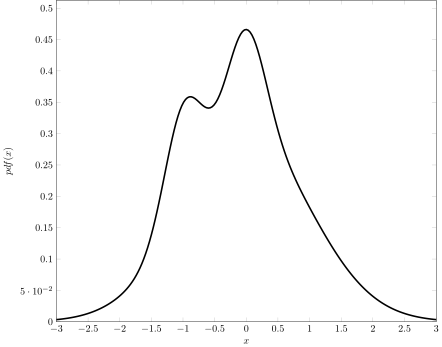

In [4]:
using Distributions

true_dist = MixtureModel([Normal(0.0,0.3),Normal(-1.0,0.3),Normal(0.0,1.0)], [0.125,0.125,0.75])
x_vals = range(-3,stop=3,length=201)
line_true = PGFPlots.Plots.Linear(x_vals, map(x->pdf(true_dist, x), x_vals), style="black, ultra thick, mark=none")
Axis(line_true, xlabel=L"x", ylabel=L"pdf(x)", ymin=0, xmin=minimum(x_vals), xmax=maximum(x_vals), width="15cm")

You want to get the _best_ model for this distribution. The problem is, all you have to train on is a sample dataset:

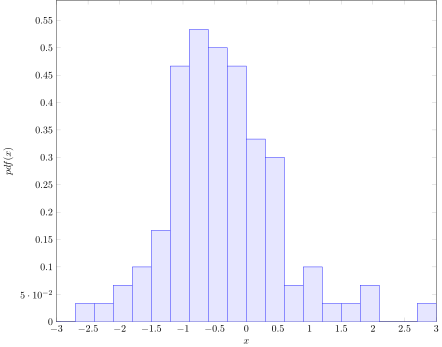

In [5]:
using Random

Random.seed!(0)
samples = rand(true_dist, 100)
Axis(PGFPlots.Plots.Histogram(samples, bins=20, density=true), 
xlabel=L"x", ylabel=L"pdf(x)", ymin=0, xmin=minimum(x_vals), xmax=maximum(x_vals), width="15cm")

Suppose we want to use a piecewise uniform distribution with even bin widths. Above I used 20 bins to create one. How do we select the _best_ number of bins?

In [6]:
using Interact

@manipulate for nbins in [1,2,3,4,5,10,20,50,100]
    Axis([PGFPlots.Plots.Histogram(samples, bins=nbins, density=true), line_true],
        xlabel=L"x", ylabel=L"pdf(x)", ymin=0, xmin=minimum(x_vals), xmax=maximum(x_vals), width="15cm")
end

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/790a2899848cb55930c57eec87df6d5182e9094b-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/790a2899848cb55930c57eec87df6d5182e9094b-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:nbins=>Widget{:slider,Int64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:index=>Observable{Any} with 2 listeners. Value:
5,:formatted_vals=>Observable{Any} with 1 listeners. Value:
["1", "2", "3", "4", "5", "10", "20", "50", "100"],:formatted_value=>Observable{String} with 1 listeners. Value:
"5",:value=>Observable{Int64} with 2 listeners. Value:
5), Observable{Int64} with 2 listeners. Value:
5, Scope("knockout-component-a7a09488-cd37-4391-828d-448c32d0e0bf", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["nbins"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-left")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>9,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-center")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-right")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("formatted_vals"=>(Observable{Any} with 1 listeners. Value:
["1", "2", "3", "4", "5", "10", "20", "50", "100"], nothing),"changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"formatted_value"=>(Observable{String} with 1 listeners. Value:
"5", nothing),"index"=>(Observable{Any} with 2 listeners. Value:
5, nothing)), Set(String[]), nothing, Any["knockout"=>"C:\\Users\\mykel\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout.js", "knockout_punches"=>"C:\\Users\\mykel\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout_punches.js", "C:\\Users\\mykel\\.julia\\packages\\InteractBase\\3SqBl\\src\\..\\assets\\all.js", "C:\\Users\\mykel\\.julia\\packages\\InteractBase\\3SqBl\\src\\..\\assets\\style.css", "C:\\Users\\mykel\\.julia\\packages\\InteractBulma\\Ohu5Y\\src\\..\\assets\\main.css"], Dict{Any,Any}("formatted_vals"=>Any[JSString("(function (val){return (val!=this.model[\"formatted_vals\"]()) ? (this.valueFromJulia[\"formatted_vals\"]=true, this.model[\"formatted_vals\"](val)) : undefined})")],"_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"formatted_vals\\\":[\\\"1\\\",\\\"2\\\",\\\"3\\\",\\\"4\\\",\\\"5\\\",\\\"10\\\",\\\"20\\\",\\\"50\\\",\\\"100\\\"],\\\"changes\\\":0,\\\"formatted_value\\\":\\\"5\\\",\\\"index\\\":5}\");\n    var self = this;\n    function AppViewModel(

Clearly the correct number is somewhere between 5 and 100, but what should we use? Remember, we don't have access to the true distribution.

One approach to use is to do a _train-test split_.

This involves taking the available data and using some to fit the distribution and the rest to check the fitness:

In [7]:
samples_train = samples[1:90]
samples_test = samples[91:end];

We can then use some metric, perhaps the likelihood of the test data under the learned model, to select the preferred nbins.

This approach tests the ability of your model to generalize to unseen data.

In [8]:
using Discretizers

function get_likelihood(samples_train, nbins, samples_test)
    lo, hi = extrema([samples_train; samples_test])
    disc = LinearDiscretizer(range(lo,stop=hi,length=nbins+1))
    counts = zeros(Int, nbins)
    for v in samples_train
        counts[encode(disc, v)] += 1
    end
    
    N = sum(counts)
    likelihood = 1.0
    for v in samples_test
        bin = encode(disc,v)
        prob_of_bin = counts[bin] / N
        prob_within_bin = 1/binwidth(disc, bin)
        likelihood *= prob_of_bin*prob_within_bin
    end
    likelihood
end;

In [9]:
using Printf

@manipulate for nbins in [1,2,3,4,5,10,20,50,100]
    Axis([PGFPlots.Plots.Histogram(samples_train, bins=nbins, density=true), line_true],
    xlabel=L"x", ylabel=L"pdf(x)", title=@sprintf("\\Large Likelihood: %10.8f", get_likelihood(samples_train, nbins, samples_test)), 
    ymin=0, xmin=minimum(x_vals), xmax=maximum(x_vals), width="15cm")
end

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:nbins=>Widget{:slider,Int64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:index=>Observable{Any} with 2 listeners. Value:
5,:formatted_vals=>Observable{Any} with 1 listeners. Value:
["1", "2", "3", "4", "5", "10", "20", "50", "100"],:formatted_value=>Observable{String} with 1 listeners. Value:
"5",:value=>Observable{Int64} with 2 listeners. Value:
5), Observable{Int64} with 2 listeners. Value:
5, Scope("knockout-component-87e299f7-f9d4-493d-bf5e-c06dbb31b34d", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["nbins"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-left")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>9,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-center")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-right")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("formatted_vals"=>(Observable{Any} with 1 listeners. Value:
["1", "2", "3", "4", "5", "10", "20", "50", "100"], nothing),"changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"formatted_value"=>(Observable{String} with 1 listeners. Value:
"5", nothing),"index"=>(Observable{Any} with 2 listeners. Value:
5, nothing)), Set(String[]), nothing, Any["knockout"=>"C:\\Users\\mykel\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout.js", "knockout_punches"=>"C:\\Users\\mykel\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout_punches.js", "C:\\Users\\mykel\\.julia\\packages\\InteractBase\\3SqBl\\src\\..\\assets\\all.js", "C:\\Users\\mykel\\.julia\\packages\\InteractBase\\3SqBl\\src\\..\\assets\\style.css", "C:\\Users\\mykel\\.julia\\packages\\InteractBulma\\Ohu5Y\\src\\..\\assets\\main.css"], Dict{Any,Any}("formatted_vals"=>Any[JSString("(function (val){return (val!=this.model[\"formatted_vals\"]()) ? (this.valueFromJulia[\"formatted_vals\"]=true, this.model[\"formatted_vals\"](val)) : undefined})")],"_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"formatted_vals\\\":[\\\"1\\\",\\\"2\\\",\\\"3\\\",\\\"4\\\",\\\"5\\\",\\\"10\\\",\\\"20\\\",\\\"50\\\",\\\"100\\\"],\\\"changes\\\":0,\\\"formatted_value\\\":\\\"5\\\",\\\"index\\\":5}\");\n    var self = this;\n    function AppViewModel(

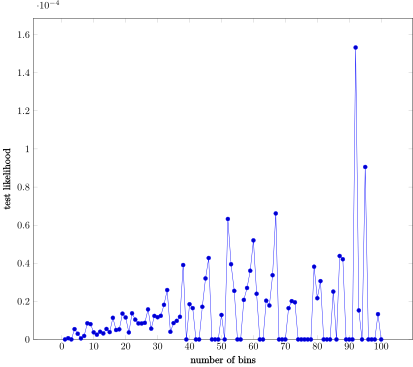

In [10]:
Axis(Plots.Linear(collect(1:100), map(i->get_likelihood(samples_train, i, samples_test), 1:100)), 
xlabel="number of bins", ylabel="test likelihood", ymin=0.0, width="15cm")

Two things:

1 - Notice how small the likelihoods are? Maximizing the log likelihood gives the same result but with nicer numbers
2 - Notice those zeros? Those occur whenever we have a training sample with zero likelihood. We can add a _prior_ of one count to each bin to ensure that we get some support. This is also called _Laplace Smoothing_.

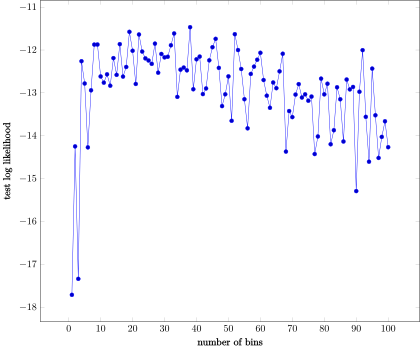

In [11]:
function get_loglikelihood(samples_train, nbins, samples_test)
    lo, hi = extrema([samples_train; samples_test])
    disc = LinearDiscretizer(range(lo,stop=hi,length=nbins+1))
    counts = ones(Int, nbins) # add Laplace Smoothing
    for v in samples_train
        counts[encode(disc, v)] += 1
    end
    
    N = sum(counts)
    loglikelihood = 0.0
    for v in samples_test
        bin = encode(disc,v)
        prob_of_bin = counts[bin] / N
        prob_within_bin = 1/binwidth(disc, bin)
        loglikelihood += log(prob_of_bin) + log(prob_within_bin)
    end
    loglikelihood
end

Axis(Plots.Linear(collect(1:100), map(i->get_loglikelihood(samples_train, i, samples_test), 1:100)), 
xlabel="number of bins", ylabel="test log likelihood", width="15cm")

Train-test splitting is pretty good, but we can do even better if we do this over multiple train-test splits. _Cross Validation_ is one common way of doing this.

In $k$-fold cross validation, you take your training data and divide it into $k$ even chunks. For each chunk, you

- train on all of the $k-1$ other chunks
- test on the chunk

And then take the average over all $k$ validation scores to get your cross-validated score.

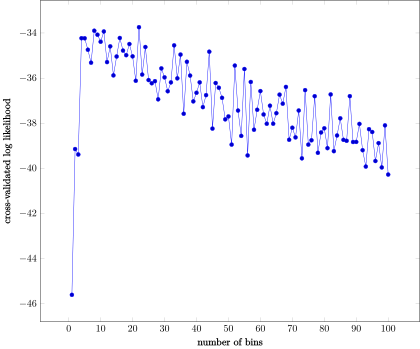

In [12]:
fold1 = samples[ 1:25]
fold2 = samples[25:50]
fold3 = samples[50:75]
fold4 = samples[75:100]
function get_cv_score(nbins)
    score1 = get_loglikelihood([fold1; fold2; fold3], nbins, fold4)
    score2 = get_loglikelihood([fold2; fold3; fold4], nbins, fold1)
    score3 = get_loglikelihood([fold3; fold4; fold1], nbins, fold2)
    score4 = get_loglikelihood([fold4; fold1; fold2], nbins, fold3)
    mean([score1, score2, score3, score4])
end

Axis(Plots.Linear(collect(1:100), map(i->get_cv_score(i), 1:100)), 
xlabel="number of bins", ylabel="cross-validated log likelihood", width="15cm")

## Measuring the 'Closeness' of Distributions

One often needs to measure the closeness of two distributions, such as when comparing distributions over emergent metrics to their real-world counterparts.

For example, if you create a car that is supposed to drive like a human, does it tend to drive with the same following distance as a real car does?

We can all agree that the following two distributions are close.

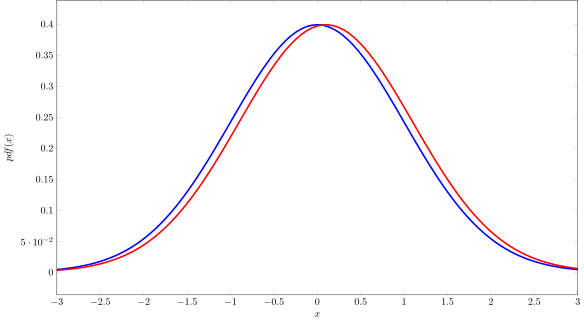

In [13]:
real = Normal(0.0, 1.0)
plot_distr = (sim, x_vals) ->  Axis([PGFPlots.Linear(x_vals, map(x->pdf(real, x), x_vals), style="mark=none, ultra thick"), 
                                     PGFPlots.Linear(x_vals, map(x->pdf(sim, x), x_vals), style="mark=none, ultra thick")], 
                                      width="20cm", height="12cm", xmin=minimum(x_vals), xmax=maximum(x_vals), xlabel=L"x", ylabel=L"pdf(x)")

plot_distr(Normal(0.1, 1.0), range(-3.0, stop=3.0, length=101))

We can all agree that the following two distributions are less close.

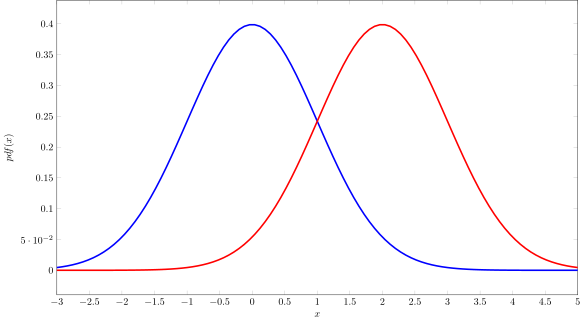

In [14]:
plot_distr(Normal(2.0, 1.0), range(-3.0, stop=5.0, length=101))

How close are these distributions?

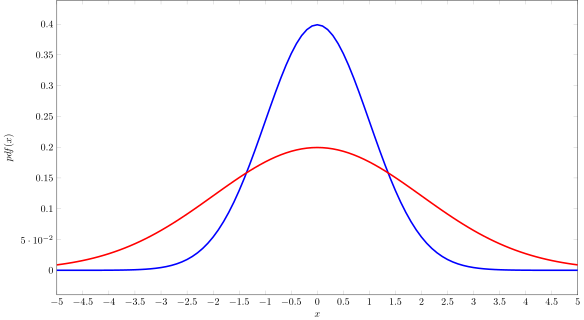

In [15]:
plot_distr(Normal(0.0, 2.0), range(-5.0, stop=5.0, length=101))

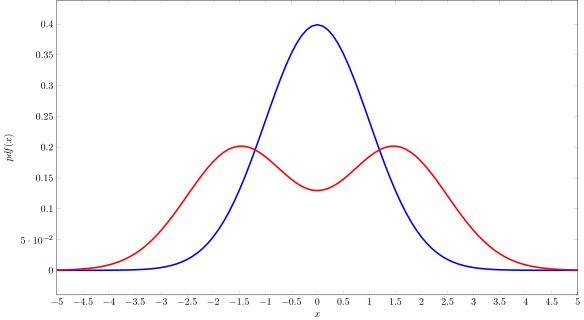

In [16]:
plot_distr(MixtureModel([Normal(-1.5, 1.0), Normal(1.5, 1.0)]), range(-5.0, stop=5.0, length=101))

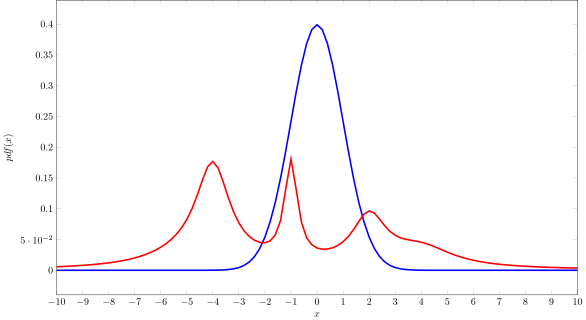

In [17]:
sim = MixtureModel([Cauchy(-5, 1.8), Cauchy(-4, 0.8), Cauchy(-1, 0.3), Cauchy(2, 0.8), Cauchy(4, 1.5)], [0.1, 0.4, 0.15, 0.2, 0.15])
plot_distr(sim, range(-10.0, stop=10.0, length=101))

The Kullbeck Leibler divergence is one way to measure closeness. It actually measures divergence, the opposite of closeness.

$$D_{KL}(p \| q) = \int_{-\infty}^{\infty} p(x) \log \frac{p(x)}{q(x)} \, dx $$

It is 0 if the two distributions are the same and increases if they are different.

Note that it is non-symmetric, so $D_{KL}(p \| q) \neq D_{KL}(q \| p)$.  Here, $p$ is the true distribution and $q$ is what is being used to approximate $p$.

In [18]:
x_vals = range(-5.0, stop=5.0, length=101)
@manipulate for μ in range(-2,stop=2,length=11), σ in range(0.1,stop=4.0,length=11)
    ax = plot_distr(Normal(μ, σ), range(-10.0, stop=10.0, length=101))
    ax.title = @sprintf("KLdiv = %.3f", log(σ) + (1 + μ^2)/(2*σ^2) - 0.5) # KLdiv for 2 Gaussians
    ax.ymin = 0
    ax.ymax = 0.5
    ax
end

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:μ=>Widget{:slider,Float64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:index=>Observable{Any} with 2 listeners. Value:
6,:formatted_vals=>Observable{Any} with 1 listeners. Value:
["-2.0", "-1.6", "-1.2", "-0.8", "-0.4", "0.0", "0.4", "0.8", "1.2", "1.6", "2.0"],:formatted_value=>Observable{String} with 1 listeners. Value:
"0.0",:value=>Observable{Float64} with 2 listeners. Value:
0.0), Observable{Float64} with 2 listeners. Value:
0.0, Scope("knockout-component-b7407840-2421-495a-8e57-42ea7a0e0915", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["μ"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-left")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>11,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-center")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-right")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("formatted_vals"=>(Observable{Any} with 1 listeners. Value:
["-2.0", "-1.6", "-1.2", "-0.8", "-0.4", "0.0", "0.4", "0.8", "1.2", "1.6", "2.0"], nothing),"changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"formatted_value"=>(Observable{String} with 1 listeners. Value:
"0.0", nothing),"index"=>(Observable{Any} with 2 listeners. Value:
6, nothing)), Set(String[]), nothing, Any["knockout"=>"C:\\Users\\mykel\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout.js", "knockout_punches"=>"C:\\Users\\mykel\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout_punches.js", "C:\\Users\\mykel\\.julia\\packages\\InteractBase\\3SqBl\\src\\..\\assets\\all.js", "C:\\Users\\mykel\\.julia\\packages\\InteractBase\\3SqBl\\src\\..\\assets\\style.css", "C:\\Users\\mykel\\.julia\\packages\\InteractBulma\\Ohu5Y\\src\\..\\assets\\main.css"], Dict{Any,Any}("formatted_vals"=>Any[JSString("(function (val){return (val!=this.model[\"formatted_vals\"]()) ? (this.valueFromJulia[\"formatted_vals\"]=true, this.model[\"formatted_vals\"](val)) : undefined})")],"_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"formatted_vals\\\":[\\\"-2.0\\\",\\\"-1.6\\\",\\\"-1.2\\\",\\\"-0.8\\\",\\\"-0.4\\\",\\\"0.0\\\",\\\"0.4\\\",\\\"0.8\\\",\\\"1.2\\\",\\\"1.6\\\",\\\"2.0\\\"],\\\"chang

## Assignment

Your homework is to:

- Run your collision avoidance system on the training set and pick three encounters where the system fails. Why does it fail? Is this a problem with your design? How might it be fixed?
- Run your collision avoidance system on the training set and compute:
   - the number of NMACs
   - the number of NMACs in which no advisory was issued
   - a histogram over the aircraft separation distance when advisories were issued
   - a scatter plot of relative horizontal separation vs. relative vertical separation when advisories were issued
   - a scatter plot of vehicle bearing the clockwise bearing from your craft to the intruder at the encounter start vs. the clockwise heading of the intruder relative to the positive north axis (See Lecture 4) for when advisories were issued
- Choose a meaninful tuneable parameter in your collision avoidance system, or change your system to include a meaningful tuneable parameter. (For example, a parameter in the Alpha-Beta filter). Use $5$-fold cross validation over the training dataset and plot the cross-validated-normalized-penalty with respect to the tuneable parameter.

Turn in your code and writeup (preferably a single Julia Notebook) to Canvas.